In [1]:
import mne
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout,TimeDistributed,GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE

In [3]:
# โหลดข้อมูล
df = pd.read_csv("C:\\Users\\HP\\Desktop\\LSTM\\\merged_eeg_events.csv")

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
C:\Users\HP\AppData\Local\Temp\ipykernel_23740\2341127673.py:2: SyntaxWarning: invalid escape sequence '\m'
  df = pd.read_csv("C:\\Users\\HP\\Desktop\\LSTM\\\merged_eeg_events.csv")


In [4]:
channel_map = {
    "1": "EEG F4-M1",
    "2": "EEG C4-M1",
    "3": "EEG O2-M1",
    "4": "EEG C3-M2",
    "5": "EMG chin",
    "6": "EOG E1-M2",
    "7": "EOG E2-M2",
    "8": "ECG"
}
# เปลี่ยนชื่อ column ใน DataFrame
df = df.rename(columns=channel_map)

# ตรวจสอบ
print(df.head())

       Time  EEG F4-M1  EEG C4-M1  EEG O2-M1  EEG C3-M2  EMG chin  EOG E1-M2  \
0  0.000000  17.126726  14.758526  38.342870   5.896086 -4.528878   3.747616   
1  0.003906  18.225376  15.564202  37.122148   5.456626  1.403830  10.998703   
2  0.007812  17.590600  10.632486  24.109255   7.580682  0.231937  21.643397   
3  0.011719  10.949874   2.941939  13.000687   6.433204 -0.231937  27.405203   
4  0.015625   5.822843   1.647974  18.030060   3.381399  2.868696  26.306554   

   EOG E2-M2        ECG      Annotation  
0  -9.289693  73.719387   Sleep stage W  
1 -10.901045  70.936141   Sleep stage W  
2  -9.509422  69.398032   Sleep stage W  
3 -11.413748  65.149920   Sleep stage W  
4 -14.612039  57.605859   Sleep stage W  


In [5]:
data = df.drop(['Annotation','Time'], axis=1)
labels = df['Annotation']

In [6]:
# train-test split for time series
train_size = int(len(data) * 0.5)
val_size = int(len(data) * 0.75)

X_train_df = data[:train_size]
X_val_df = data[train_size:val_size]
X_test_df = data[val_size:]

y_train_df = labels[:train_size]
y_val_df = labels[train_size:val_size]
y_test_df = labels[val_size:]


In [7]:
y_train_df.value_counts(), y_val_df.value_counts(), y_test_df.value_counts()

(Annotation
 Sleep stage N2    1585920
 Sleep stage W      867840
 Sleep stage N1     529920
 Sleep stage R      199680
 Sleep stage N3      99840
 Name: count, dtype: int64,
 Annotation
 Sleep stage N2    1004160
 Sleep stage R      430080
 Sleep stage N1     130560
 Sleep stage N3      38400
 Sleep stage W       38400
 Name: count, dtype: int64,
 Annotation
 Sleep stage N2    712320
 Sleep stage R     453120
 Sleep stage W     253440
 Sleep stage N1    176640
 Sleep stage N3     38400
 Name: count, dtype: int64)

## Undersampling

In [9]:

# รวม features และ labels เข้าด้วยกันชั่วคราว
train_df = X_train_df.copy()
train_df['Annotation'] = y_train_df.values


print(train_df['Annotation'].value_counts())


min_count = train_df['Annotation'].value_counts().min()


balanced_train_df = (
    train_df.groupby('Annotation', group_keys=False)
    .apply(lambda x: x.sample(n=min_count, random_state=42))
    .reset_index(drop=True)
)


X_train_balanced = balanced_train_df.drop('Annotation', axis=1)
y_train_balanced = balanced_train_df['Annotation']


print("After undersampling:")
print(y_train_balanced.value_counts())


Annotation
Sleep stage N2    1585920
Sleep stage W      867840
Sleep stage N1     529920
Sleep stage R      199680
Sleep stage N3      99840
Name: count, dtype: int64
After undersampling:
Annotation
Sleep stage N1    99840
Sleep stage N2    99840
Sleep stage N3    99840
Sleep stage R     99840
Sleep stage W     99840
Name: count, dtype: int64


C:\Users\HP\AppData\Local\Temp\ipykernel_23740\2023164288.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_count, random_state=42))


In [10]:
X_train_df.shape, X_val_df.shape, X_test_df.shape

((3283200, 8), (1641600, 8), (1641600, 8))

C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


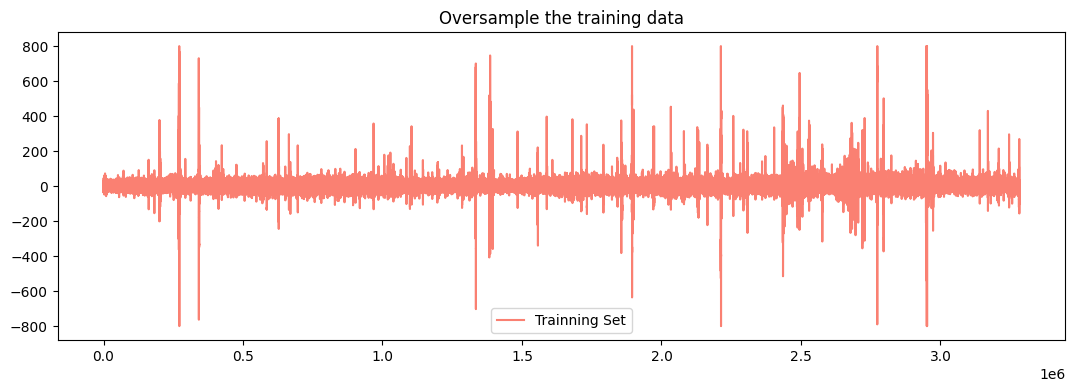

In [11]:
plt.figure(figsize=(13,4))
plt.plot(X_train_df['EEG F4-M1'], color='salmon', label='Trainning Set')
plt.legend()
plt.title('Oversample the training data')
plt.show()

In [20]:
selected_channels = ['EEG F4-M1', 'EEG C4-M1', 'EEG O2-M1', 'EEG C3-M2']

X_train_balanced_reduced = X_train_balanced[selected_channels]
X_val_reduced = X_val_df[selected_channels]
X_test_reduced = X_test_df[selected_channels]
X_train_balanced_reduced.shape,X_val_reduced.shape,X_test_reduced.shape

((499200, 4), (1641600, 4), (1641600, 4))

## Sliding Window

In [16]:
X_train_balanced, y_train_balanced


(        EEG F4-M1  EEG C4-M1  EEG O2-M1   EEG C3-M2  EMG chin   EOG E1-M2  \
 0       -2.844282   6.775006  -1.721218   23.938354  0.573739   47.742428   
 1       29.529259  20.300603   0.085451   16.247807  0.793469  -10.241855   
 2       -3.088426  -5.969329   9.900053   -3.942931 -1.135271   43.836118   
 3       15.417716  21.887541  14.563210    5.139239  2.063020  -18.078889   
 4       18.200961  14.612039  17.346456   -1.208515  8.825818  -38.953231   
 ...           ...        ...        ...         ...       ...         ...   
 499195  12.072938  23.962768  11.267262   12.756542  3.503471   -9.851225   
 499196   1.965362 -26.965743 -14.587625  -34.143587  8.581674  -12.976272   
 499197  12.683299  30.286107  31.555657 -295.378042  5.700771 -320.183108   
 499198   0.500496   0.646983  -5.261311  -12.365911 -0.817884   -1.208515   
 499199 -22.571145  -3.552300 -10.193027   14.978256  3.649958   13.806363   
 
          EOG E2-M2         ECG  
 0        -1.159686   51.599

In [13]:
def apply_sliding_window(data, label, window_size, step_size):
    # Reset index เพื่อให้ iloc ทำงานได้แน่นอน
    data = data.reset_index(drop=True)
    label = label.reset_index(drop=True)

    window_data = []
    window_label = []

    for i in range(0, len(data) - window_size + 1, step_size):
        window = data.iloc[i:i + window_size]
        label_slice = label.iloc[i:i + window_size]

        # ตรวจว่าทั้ง window มี label เดียวกันไหม
        unique_labels = label_slice.unique()
        if len(unique_labels) == 1:  # ✅ มีคลาสเดียว
            window_data.append(window)
            window_label.append(unique_labels[0])
        else:
            continue  # 🚫 ถ้ามีมากกว่า 1 คลาส -> ข้ามเลย

    X = np.array(window_data)
    y = np.array(window_label)
    return X, y

In [24]:
window_size = 256
step_size = 128

# ชุด original
X_train, y_train = apply_sliding_window(X_train_df, y_train_df, window_size, step_size)
X_val, y_val = apply_sliding_window(X_val_df, y_val_df, window_size, step_size)
X_test, y_test = apply_sliding_window(X_test_df, y_test_df, window_size, step_size)

X_train_reduced, y_train_reduced = apply_sliding_window(X_train_df_reduced, y_train_df, window_size, step_size)
X_val_reduced, y_val_reduced = apply_sliding_window(X_val_df_reduced, y_val_df, window_size, step_size)
X_test_reduced, y_test_reduced = apply_sliding_window(X_test_df_reduced, y_test_df, window_size, step_size)

# ----------------------------
# 4️⃣ Print shape ทั้งหมด
# ----------------------------
print("\nOriginal (all channels):", X_train.shape, y_train.shape)
print("Reduced (4 channels):", X_train_reduced.shape, y_train_reduced.shape)
print("Balanced (all channels):", X_train_bal.shape, y_train_bal.shape)
print("Balanced + Reduced (4 channels):", X_train_bal_reduced.shape, y_train_bal_reduced.shape)


Original (all channels): (25590, 256, 8) (25590,)
Reduced (4 channels): (25590, 256, 4) (25590,)
Balanced (all channels): (3895, 256, 8) (3895,)
Balanced + Reduced (4 channels): (3895, 256, 4) (3895,)


In [28]:



print("After Sliding Window (y_train_reduced):")
print(pd.Series(y_train_reduced).value_counts(), "\n")

# รวมเป็นตารางเปรียบเทียบ
annotation_check = pd.DataFrame({
    "After Undersampling": y_train_balanced.value_counts(),
    "After (Window)": pd.Series(y_train_reduced).value_counts()
}).fillna(0).astype(int)

print("=== Comparison Table ===")
print(annotation_check)


# --------------------------
# แสดงสัดส่วน (%) ของ class ก่อน window
# --------------------------
print("=== Percentage Before Sliding Window ===")
print((y_train_df.value_counts(normalize=True) * 100).round(2))


After Sliding Window (y_train_reduced):
Sleep stage N2    12369
Sleep stage W      6772
Sleep stage N1     4118
Sleep stage R      1556
Sleep stage N3      775
Name: count, dtype: int64 

=== Comparison Table ===
                After Undersampling  After (Window)
Sleep stage N1                99840            4118
Sleep stage N2                99840           12369
Sleep stage N3                99840             775
Sleep stage R                 99840            1556
Sleep stage W                 99840            6772
=== Percentage Before Sliding Window ===
Annotation
Sleep stage N2    48.30
Sleep stage W     26.43
Sleep stage N1    16.14
Sleep stage R      6.08
Sleep stage N3     3.04
Name: proportion, dtype: float64


In [23]:
print("=== After Sliding Window (All Sets) ===\n")

sets = {
    "Train (Original)": y_train,
    "Val (Original)": y_val,
    "Test (Original)": y_test,
    "Train (Reduced)": y_train_reduced,
    "Train (Balanced)": y_train_bal,
    "Train (Balanced+Reduced)": y_train_bal_reduced
}

summary = {}
for name, y in sets.items():
    value_counts = pd.Series(y).value_counts()
    summary[name] = value_counts
    print(f"\n{name}:")
    print(value_counts)
    print("-" * 40)

# ----------------------------
# 2️⃣ รวมผลทั้งหมดในตารางเดียว
# ----------------------------
annotation_summary = pd.DataFrame(summary).fillna(0).astype(int)
print("\n=== Summary Table ===")
print(annotation_summary)

=== After Sliding Window (All Sets) ===


Train (Original):
Sleep stage N2    12369
Sleep stage W      6772
Sleep stage N1     4118
Sleep stage R      1556
Sleep stage N3      775
Name: count, dtype: int64
----------------------------------------

Val (Original):
Sleep stage N2    7838
Sleep stage R     3358
Sleep stage N1    1014
Sleep stage N3     299
Sleep stage W      299
Name: count, dtype: int64
----------------------------------------

Test (Original):
 Sleep stage N2    5558
 Sleep stage R     3538
 Sleep stage W     1975
 Sleep stage N1    1372
 Sleep stage N3     298
nan                  59
Name: count, dtype: int64
----------------------------------------

Train (Reduced):
Sleep stage N2    12369
Sleep stage W      6772
Sleep stage N1     4118
Sleep stage R      1556
Sleep stage N3      775
Name: count, dtype: int64
----------------------------------------

Train (Balanced):
Sleep stage N1    779
Sleep stage N2    779
Sleep stage N3    779
Sleep stage R     779
Sleep stage W

In [29]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# -----------------------------
# 1. แปลง label เป็นตัวเลข + one-hot
# -----------------------------
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)
y_test_enc  = encoder.transform(y_test)

num_classes = len(np.unique(y_train_enc))

y_train_cat = to_categorical(y_train_enc, num_classes=num_classes)
y_val_cat   = to_categorical(y_val_enc, num_classes=num_classes)
y_test_cat  = to_categorical(y_test_enc, num_classes=num_classes)

# -----------------------------
# 2. แปลง X ให้เป็น float32 และ shape = (samples, timesteps, features)
# -----------------------------
X_train = np.array(X_train, dtype=np.float32)
X_val   = np.array(X_val, dtype=np.float32)
X_test  = np.array(X_test, dtype=np.float32)

if X_train.ndim == 2:
    X_train = X_train[..., np.newaxis]
    X_val   = X_val[..., np.newaxis]
    X_test  = X_test[..., np.newaxis]

print("X_train shape:", X_train.shape)  # (samples, timesteps, channels)
print("y_train shape:", y_train_cat.shape)

# -----------------------------
# 3. สร้าง CNN model
# -----------------------------
model_cnn = Sequential([
    Conv1D(filters=32, kernel_size=7, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_cnn.summary()


ValueError: y contains previously unseen labels: np.str_('nan')

In [ ]:
# -----------------------------
# 4. Train CNN model
# -----------------------------
history = model_cnn.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=80,
    batch_size=32,
    shuffle=True,
)